<a href="https://colab.research.google.com/github/Shellyga/Computer-Vision-Final-Proj/blob/master/classify_mnist_with_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Experimentation on Fashion Mnist with VGG16**
To demonstrate
1) Converting images with 1 channel to 3 channels
2) Resizing the images
3) Using VGG16 base model, appending with other layers and extracting features
4) Reduce learning, early stopping in callback methods

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, time
import matplotlib.pyplot as plt
#from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
#from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16;
from keras.applications.vgg16 import preprocess_input
import os

Using TensorFlow backend.


# Mnist feature extractor with VGG16

In [3]:
mnist = keras.datasets.mnist


def get_2_labels(first_digit, second_digit):
    (x_train, y_train),(x_test, y_test) = mnist.load_data()

    # x_train = (x_train / 255.0 * 2 - 1).reshape(x_train.shape[0], -1)
    # x_test = (x_test / 255.0 * 2 - 1).reshape(x_test.shape[0], -1)

    train_images = np.logical_or((y_train == first_digit), (y_train == second_digit))
    test_images = np.logical_or((y_test == first_digit), (y_test == second_digit))
    return x_train[train_images], y_train[train_images], x_test[test_images], y_test[test_images]


train_X, train_Y, test_X, test_Y = get_2_labels(0, 1)



11493376/11490434 [==============================] - 0s 0us/step


In [4]:
classes = np.unique(train_Y)
num_classes = len(classes)
num_classes

2

In [5]:
# Convert the images into 3 channels
train_X=np.dstack([train_X] * 3)
test_X=np.dstack([test_X]*3)
train_X.shape,test_X.shape

((12665, 28, 84), (2115, 28, 84))

In [6]:
# Reshape images as per the tensor format required by tensorflow
train_X = train_X.reshape(-1, 28,28,3)
test_X= test_X.reshape (-1,28,28,3)
train_X.shape,test_X.shape

((12665, 28, 28, 3), (2115, 28, 28, 3))

In [7]:
# Resize the images 48*48 as required by VGG16
from keras.preprocessing.image import img_to_array, array_to_img
train_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in train_X])
test_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in test_X])
#train_x = preprocess_input(x)
train_X.shape, test_X.shape

((12665, 48, 48, 3), (2115, 48, 48, 3))

In [8]:
# Normalise the data and change data type
train_X = train_X / 255.
test_X = test_X / 255.
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

In [10]:
# Converting Labels to one hot encoded format
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

In [11]:
# Splitting train data as train and validation data
train_X,valid_X,train_label,valid_label = train_test_split(train_X,
                                                           train_Y_one_hot,
                                                           test_size=0.2,
                                                           random_state=13
                                                           )

In [12]:
# Finally check the data size whether it is as per tensorflow and VGG16 requirement
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((10132, 48, 48, 3), (2533, 48, 48, 3), (10132, 2), (2533, 2))

In [13]:
# Define the parameters for instanitaing VGG16 model. 
IMG_WIDTH = 48
IMG_HEIGHT = 48
IMG_DEPTH = 3
BATCH_SIZE = 16

In [14]:
# Preprocessing the input 
train_X = preprocess_input(train_X)
valid_X = preprocess_input(valid_X)
test_X  = preprocess_input (test_X)

In [15]:
#  Create base model of VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False, 
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                 )
conv_base.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
______________________________________________________________

In [16]:
# Extracting features
train_features = conv_base.predict(np.array(train_X), batch_size=BATCH_SIZE, verbose=1)
test_features = conv_base.predict(np.array(test_X), batch_size=BATCH_SIZE, verbose=1)
val_features = conv_base.predict(np.array(valid_X), batch_size=BATCH_SIZE, verbose=1)


2533/2533 [==============================] - 60s 24ms/step


In [ ]:
# 6.1 Saving the features so that they can be used for future
np.savez("train_features", train_features, train_label)
np.savez("test_features", test_features, test_Y)
np.savez("val_features", val_features, valid_label)

In [ ]:
# Current shape of features
print(train_features.shape, "\n",  test_features.shape, "\n", val_features.shape)

(10132, 1, 1, 512) 
 (2115, 1, 1, 512) 
 (2533, 1, 1, 512)


In [17]:
# Flatten extracted features
train_features_flat = np.reshape(train_features, (10132, 1*1*512))
test_features_flat = np.reshape(test_features, (2115, 1*1*512))
val_features_flat = np.reshape(val_features, (2533, 1*1*512))

# Classify with NN

In [ ]:
from keras import models
from keras.models import Model
from keras import layers
from keras import optimizers
from keras import callbacks
from keras.layers.advanced_activations import LeakyReLU

In [ ]:
# 7.0 Define the densely connected classifier followed by leakyrelu layer and finally dense layer for the number of classes
NB_TRAIN_SAMPLES = train_features_flat.shape[0]
NB_VALIDATION_SAMPLES = val_features_flat.shape[0]
NB_EPOCHS = 100

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=(1*1*512)))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(num_classes, activation='softmax'))

In [ ]:
# Compile the model.
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
  # optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc'])

In [ ]:
# Incorporating reduced learning and early stopping for callback
reduce_learning = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    epsilon=0.0001,
    cooldown=2,
    min_lr=0)

eary_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

callbacks = [reduce_learning, eary_stopping]

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [ ]:
# Train the the model
history = model.fit(
    train_features_flat,
    train_label,
    epochs=NB_EPOCHS,
    validation_data=(val_features_flat, valid_label),
    callbacks=callbacks
)

Train on 10132 samples, validate on 2533 samples
Epoch 1/100
10132/10132 [==============================] - 2s 195us/step - loss: 0.1711 - acc: 0.9433 - val_loss: 0.0923 - val_acc: 0.9771
Epoch 2/100
10132/10132 [==============================] - 2s 169us/step - loss: 0.0976 - acc: 0.9767 - val_loss: 0.1172 - val_acc: 0.9783
Epoch 3/100
10132/10132 [==============================] - 2s 175us/step - loss: 0.0896 - acc: 0.9777 - val_loss: 0.0743 - val_acc: 0.9783
Epoch 4/100
10132/10132 [==============================] - 2s 170us/step - loss: 0.0847 - acc: 0.9795 - val_loss: 0.0986 - val_acc: 0.9830
Epoch 5/100
10132/10132 [==============================] - 2s 175us/step - loss: 0.0737 - acc: 0.9804 - val_loss: 0.0538 - val_acc: 0.9838
Epoch 6/100
10132/10132 [==============================] - 2s 174us/step - loss: 0.0671 - acc: 0.9824 - val_loss: 0.0615 - val_acc: 0.9830
Epoch 7/100
10132/10132 [==============================] - 2s 173us/step - loss: 0.0630 - acc: 0.9822 - val_loss: 0.0

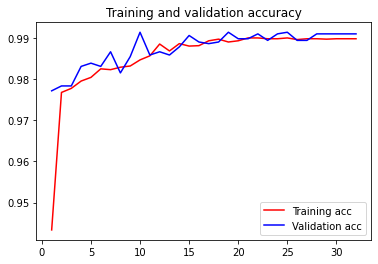

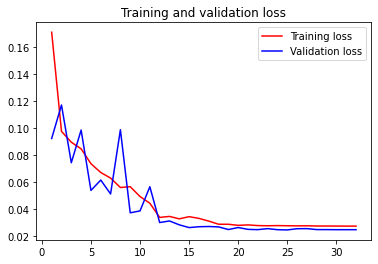

In [ ]:
# plot the loss and accuracy

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()


References
https://www.kaggle.com/crawford/diagnose-lung-disease-with-vgg16
https://www.programcreek.com/python/example/92213/keras.applications.vgg16.VGG16
http://www.socouldanyone.com/2013/03/converting-grayscale-to-rgb-with-numpy.html

# Classify with nearest neighbor

In [18]:
#Import knearest neighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
knn.fit(train_features_flat, train_label)

#Predict the response for test dataset
y_pred = knn.predict(val_features_flat)

In [19]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(valid_label, y_pred))

Accuracy: 0.9913146466640348


In [21]:
cm = metrics.confusion_matrix(valid_label[:,0], y_pred[:,0])
print("Classifier confusion matrix: ",cm)

Classifier confusion matrix:  [[1333   20]
 [   2 1178]]


In [22]:
import matplotlib.pyplot as plt
def _plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, roc_curve, auc, confusion_matrix
    import itertools
    

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black")

    plt.ylabel('True Class', fontsize = 14)
    plt.xlabel('Predicted Class', fontsize = 14)

    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()

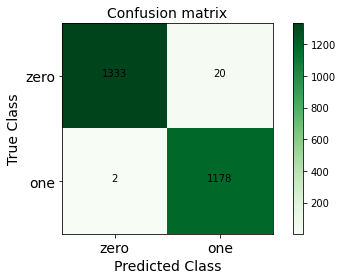

In [24]:
 _plot_confusion_matrix(cm, ['zero','one'])

# Plot results

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

n_neighbors = 5

# import some data to play with
iris = datasets.load_iris()

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = train_features_flat[:, :2]
y = train_label

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['orange',  'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'darkblue'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    print(xx.shape)
    print(yy.shape)
    print(Z[:,0].shape)
    Z = Z[:,0]
    Z = Z.reshape(xx.shape)
    
    print(Z.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # # Plot also the training points
    # plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
    #             edgecolor='k', s=20)
    # plt.xlim(xx.min(), xx.max())
    # plt.ylim(yy.min(), yy.max())
    # plt.title("3-Class classification (k = %i, weights = '%s')"
    #           % (n_neighbors, weights))

plt.show()

ValueError: ignored

(220, 280)
(220, 280)
(61600,)
(220, 280)
(220, 280)
(220, 280)
(61600,)
(220, 280)


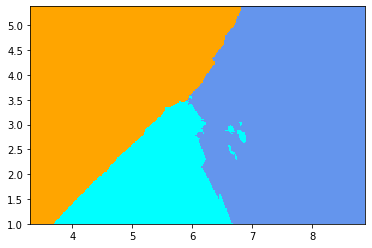

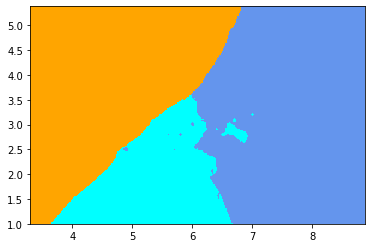

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

n_neighbors = 15

# import some data to play with
iris = datasets.load_iris()

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    print(xx.shape)
    print(yy.shape)
    print(Z.shape)
    Z = Z.reshape(xx.shape)
    print(Z.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # # Plot also the training points
    # plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
    #             edgecolor='k', s=20)
    # plt.xlim(xx.min(), xx.max())
    # plt.ylim(yy.min(), yy.max())
    # plt.title("3-Class classification (k = %i, weights = '%s')"
    #           % (n_neighbors, weights))

plt.show()